In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os


In [2]:
df = pd.read_feather("../data/output/training/training_data")

In [3]:
df.head()

,distance_traveled_wrist,wrist_x_start,wrist_y_start,wrist_z_start,wrist_x_time_25,wrist_y_time_25,wrist_z_time_25,wrist_x_time_5,wrist_y_time_5,wrist_z_time_5,...,shoulder_z_time_5,shoulder_x_time_75,shoulder_y_time_75,shoulder_z_time_75,shoulder_x_release,shoulder_y_release,shoulder_z_release,pitcher_id,sched_id,astros_pitch_id
0,13.015431,-1.0854,60.371899,5.1761,-1.2036,60.391399,5.6939,-0.9734,60.047100,5.0402,...,5.4870,-0.0581,58.776600,4.8104,-0.5841,55.591099,4.4346,680689,429650,1
0,13.302328,-1.0651,60.353500,4.7811,-1.2853,60.307598,5.6294,-1.1052,60.004902,5.1368,...,5.4980,-0.0899,58.809898,4.8387,-0.6146,55.743999,4.4007,680689,429650,2
0,12.365136,-1.1921,60.342400,5.2342,-1.2909,60.246799,5.7362,-1.0769,60.020100,4.8710,...,5.4555,-0.1301,58.790298,4.8485,-0.7695,55.674801,4.4629,680689,429650,3
0,13.664919,-1.0934,60.279400,5.0440,-1.2332,60.321999,5.7007,-1.0520,60.067402,4.9439,...,5.4231,-0.1228,58.736599,4.8103,-0.6916,55.649700,4.4210,680689,429650,4
0,15.637433,-1.0301,59.813000,5.2752,-0.5146,60.153500,4.0004,-1.3048,60.417599,5.5970,...,5.9241,-0.2401,59.987099,5.3549,-0.8248,56.023499,4.5040,680689,429650,5


In [4]:
id_cols = ['pitcher_id','sched_id', 'astros_pitch_id']
training_data = df.drop(id_cols, axis=1)


In [5]:
def plot_silhouette(X, cluster_labels, n_clusters, col_group_name: str, save: bool = False):
    fig, ax1 = plt.subplots(1, 1) 
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")


    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    plt.show()
    if save:
        fig.savefig(f"../img/{col_group_name}_{n_clusters}_silhouette.png")


In [6]:
def train_k_means(X_train:pd.DataFrame, col_group_name: str, plot: bool = True, save: bool = False):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    sse = {}
    silhouette_avg = {}
    for k in range(2, 8):
        kmeans = KMeans(n_clusters=k, n_init='auto', max_iter=100, random_state=42).fit(X_train_scaled)
        cluster_labels = kmeans.labels_
        sse[k] = round(kmeans.inertia_ , 4)
        silhouette_avg[k] = round(silhouette_score(X_train_scaled, cluster_labels), 4)
        if plot:
            plot_silhouette(X_train_scaled, cluster_labels, k, col_group_name, save)
        

    if plot:
        fig = plt.figure()
        plt.plot(list(sse.keys()), list(sse.values()))
        plt.xlabel("Number of cluster")
        plt.ylabel("SSE")
        plt.show()

    if save:
        fig.savefig(f"../img/{col_group_name}_elbow.png")

    return sse, silhouette_avg


For n_clusters = 2 The average silhouette_score is : 0.2857416586577432


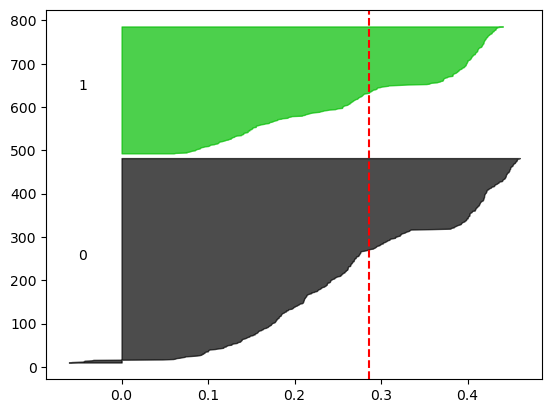

For n_clusters = 3 The average silhouette_score is : 0.3537421388377251


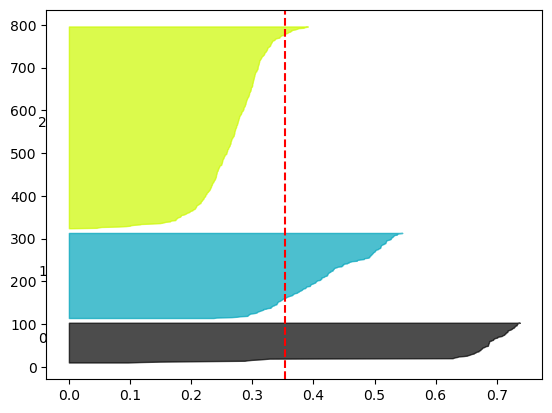

For n_clusters = 4 The average silhouette_score is : 0.37823008436772876


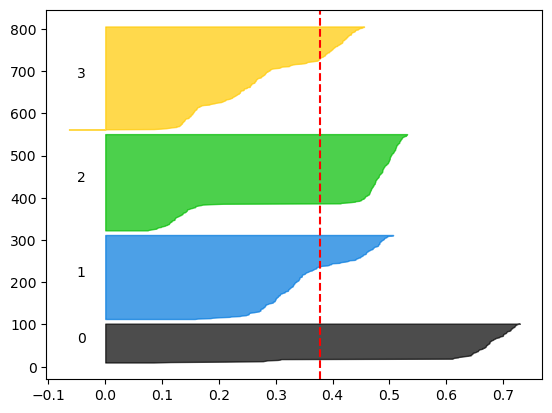

For n_clusters = 5 The average silhouette_score is : 0.4045235626415152


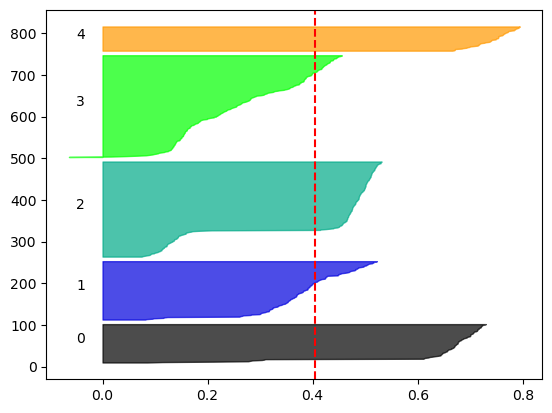

For n_clusters = 6 The average silhouette_score is : 0.4419889860743586


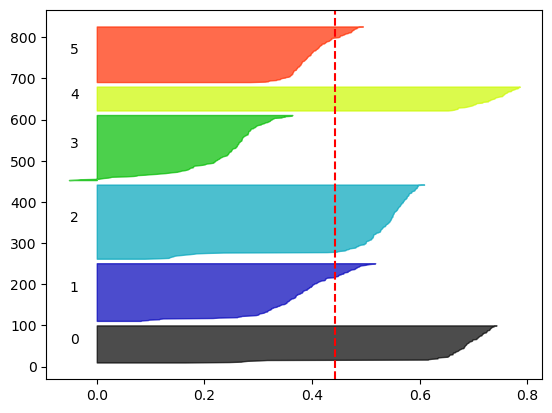

For n_clusters = 7 The average silhouette_score is : 0.5060178964945043


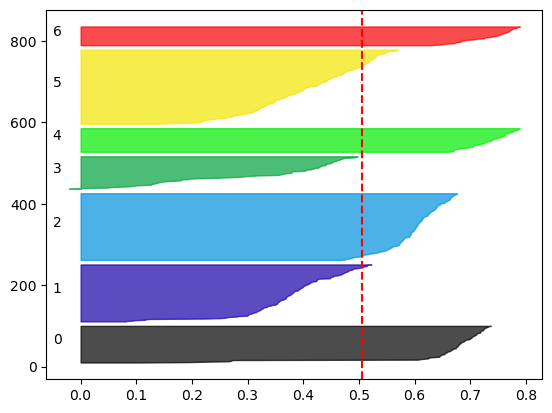

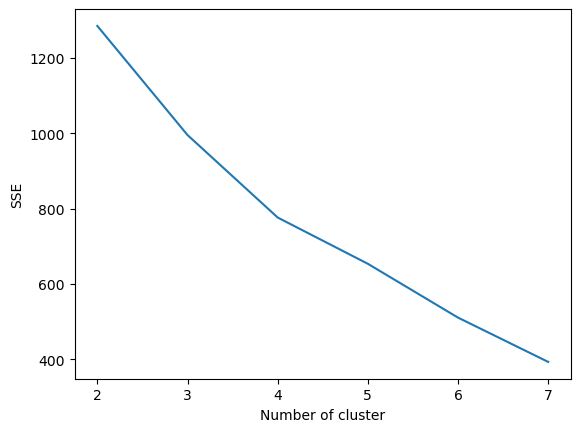

({2: 1284.6103,
  3: 995.1833,
  4: 776.3054,
  5: 653.5425,
  6: 510.7487,
  7: 393.2468},
 {2: 0.2857, 3: 0.3537, 4: 0.3782, 5: 0.4045, 6: 0.442, 7: 0.506})

In [7]:
train_k_means(training_data, "all", True, False)

In [8]:
[x for x in df.columns if 'shoulder' in x and 'y' not in x]

['distance_traveled_shoulder',
 'shoulder_x_start',
 'shoulder_z_start',
 'shoulder_x_time_25',
 'shoulder_z_time_25',
 'shoulder_x_time_5',
 'shoulder_z_time_5',
 'shoulder_x_time_75',
 'shoulder_z_time_75',
 'shoulder_x_release',
 'shoulder_z_release']

In [9]:
wrist_cols = ['distance_traveled_wrist', 'wrist_x_start', 'wrist_y_start', 'wrist_z_start', 'wrist_x_time_25', 'wrist_y_time_25', 'wrist_z_time_25', 'wrist_x_time_5', 'wrist_y_time_5', 'wrist_z_time_5', 'wrist_x_time_75', 'wrist_y_time_75', 'wrist_z_time_75', 'wrist_x_release', 'wrist_y_release', 'wrist_z_release']
wrist_and_elbow_cols = ['distance_traveled_wrist', 'wrist_x_start', 'wrist_y_start', 'wrist_z_start', 'wrist_x_time_5', 'wrist_y_time_5', 'wrist_z_time_5','wrist_x_release', 'wrist_y_release', 'wrist_z_release', 'elbow_x_start', 'elbow_y_start', 'elbow_z_start', 'elbow_x_time_5', 'elbow_y_time_5', 'elbow_z_time_5', 'elbow_x_release', 'elbow_y_release', 'elbow_z_release']
release_cols = ['wrist_x_release', 'wrist_y_release', 'wrist_z_release', 'elbow_x_release', 'elbow_y_release', 'elbow_z_release',]
wrist_elbow_midpt_release = ['wrist_x_time_5', 'wrist_y_time_5', 'wrist_z_time_5','wrist_x_release', 'wrist_y_release', 'wrist_z_release', 'elbow_x_time_5', 'elbow_y_time_5', 'elbow_z_time_5', 'elbow_x_release', 'elbow_y_release', 'elbow_z_release']
wrist_elbow_midpt_release_xz = ['wrist_x_time_5', 'wrist_z_time_5','wrist_x_release', 'wrist_z_release', 'elbow_x_time_5', 'elbow_z_time_5', 'elbow_x_release', 'elbow_z_release']
wrist_elbow_release_xz = ['wrist_x_release', 'wrist_z_release','elbow_x_release', 'elbow_z_release']
wrist_and_elbow_cols_xz = ['wrist_x_start', 'wrist_z_start', 'wrist_x_time_5', 'wrist_z_time_5','wrist_x_release', 'wrist_z_release', 'elbow_x_start', 'elbow_z_start', 'elbow_x_time_5', 'elbow_z_time_5', 'elbow_x_release', 'elbow_z_release']
all_joints_midpt_release_xz = ['wrist_x_time_5', 'wrist_z_time_5','wrist_x_release', 'wrist_z_release', 'elbow_x_time_5', 'elbow_z_time_5', 'elbow_x_release', 'elbow_z_release', 'shoulder_x_time_5', 'shoulder_z_time_5', 'shoulder_x_release', 'shoulder_z_release']
all_joints_release_xz = ['wrist_x_release', 'wrist_z_release','elbow_x_release', 'elbow_z_release', 'shoulder_x_release', 'shoulder_z_release']
all_joints_cols_xz = ['wrist_x_start', 'wrist_z_start', 'wrist_x_time_5', 'wrist_z_time_5','wrist_x_release', 'wrist_z_release', 'elbow_x_start', 'elbow_z_start', 'elbow_x_time_5', 'elbow_z_time_5', 'elbow_x_release', 'elbow_z_release', 'shoulder_x_start','shoulder_z_start', 'shoulder_x_time_25', 'shoulder_z_time_25', 'shoulder_x_time_5', 'shoulder_z_time_5', 'shoulder_x_time_75', 'shoulder_z_time_75', 'shoulder_x_release','shoulder_z_release']


cluster_cols = {}
cluster_cols['wrist_cols'] = wrist_cols
cluster_cols['wrist_and_elbow_cols'] = wrist_and_elbow_cols
cluster_cols['release_cols'] = release_cols
cluster_cols['wrist_elbow_midpt_release'] = wrist_elbow_midpt_release
cluster_cols['wrist_elbow_midpt_release_xz'] = wrist_elbow_midpt_release_xz
cluster_cols['wrist_elbow_release_xz'] = wrist_elbow_release_xz
cluster_cols['wrist_and_elbow_cols_xz'] = wrist_and_elbow_cols_xz
cluster_cols['all_joints_midpt_release_xz'] = all_joints_midpt_release_xz
cluster_cols['all_joints_release_xz'] = all_joints_release_xz
cluster_cols['all_joints_cols_xz'] = all_joints_cols_xz

In [10]:
for k,v in cluster_cols.items():
    sse, silhoutte = train_k_means(training_data[v], k, False)
    print(f"Column Group {k} silhouette: {silhoutte}")
    n = max(silhoutte, key=silhoutte.get)
    s = silhoutte[n]
    print(f"Cluster {n} with max silhouette score: {s}")

Column Group wrist_cols silhouette: {2: 0.2091, 3: 0.3413, 4: 0.3614, 5: 0.3815, 6: 0.4057, 7: 0.4332}
Cluster 7 with max silhouette score: 0.4332
Column Group wrist_and_elbow_cols silhouette: {2: 0.2755, 3: 0.3232, 4: 0.3735, 5: 0.4141, 6: 0.4312, 7: 0.4123}
Cluster 6 with max silhouette score: 0.4312
Column Group release_cols silhouette: {2: 0.3262, 3: 0.3655, 4: 0.3672, 5: 0.3521, 6: 0.3487, 7: 0.4042}
Cluster 7 with max silhouette score: 0.4041999876499176
Column Group wrist_elbow_midpt_release silhouette: {2: 0.2753, 3: 0.347, 4: 0.3554, 5: 0.38, 6: 0.4369, 7: 0.4566}
Cluster 7 with max silhouette score: 0.45660001039505005
Column Group wrist_elbow_midpt_release_xz silhouette: {2: 0.3316, 3: 0.4354, 4: 0.4759, 5: 0.494, 6: 0.5081, 7: 0.5038}
Cluster 6 with max silhouette score: 0.5080999732017517
Column Group wrist_elbow_release_xz silhouette: {2: 0.4431, 3: 0.513, 4: 0.4962, 5: 0.5365, 6: 0.5443, 7: 0.5074}
Cluster 6 with max silhouette score: 0.5443000197410583
Column Group wris

For n_clusters = 2 The average silhouette_score is : 0.4431027


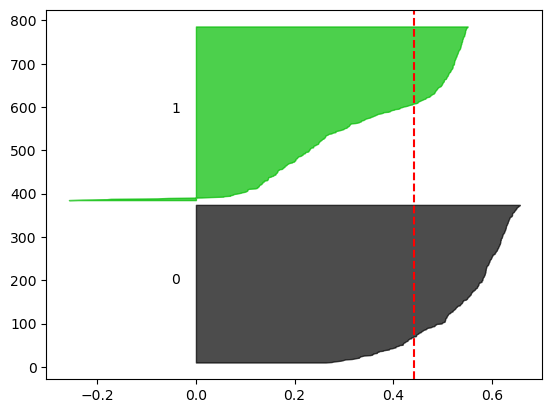

For n_clusters = 3 The average silhouette_score is : 0.5130008


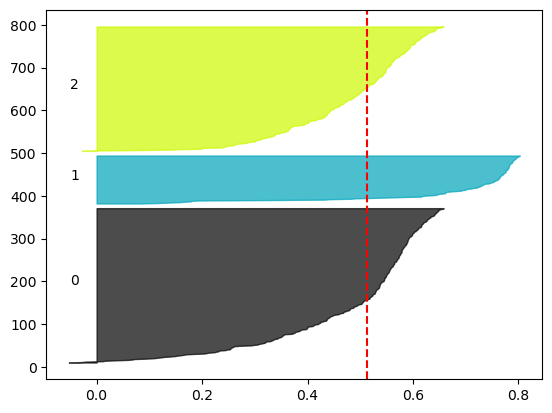

For n_clusters = 4 The average silhouette_score is : 0.49616712


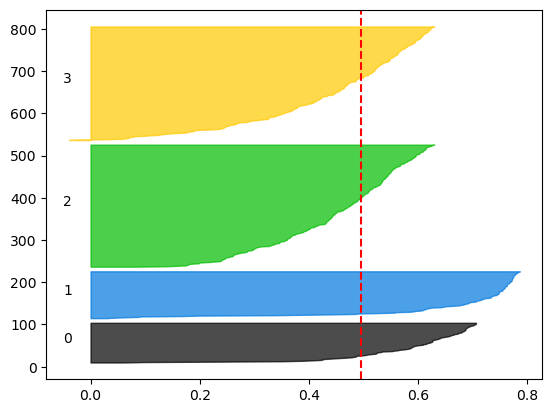

For n_clusters = 5 The average silhouette_score is : 0.5364676


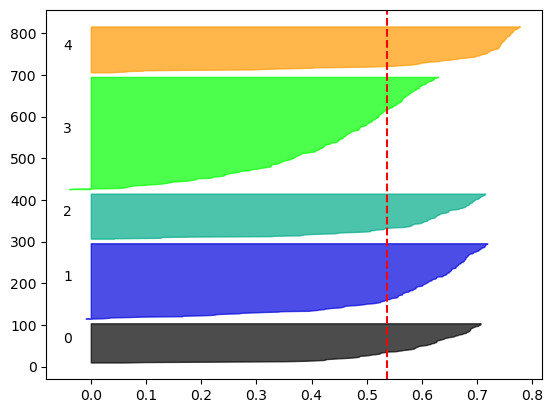

For n_clusters = 6 The average silhouette_score is : 0.54433906


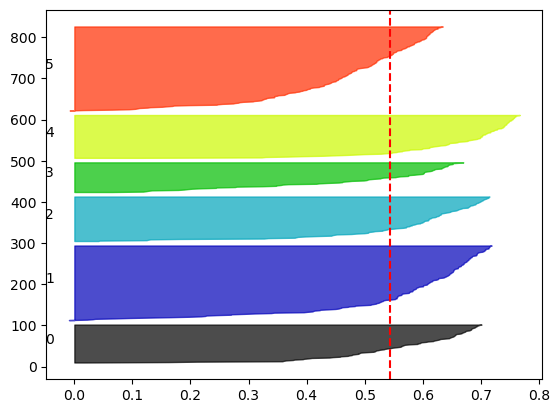

For n_clusters = 7 The average silhouette_score is : 0.50743395


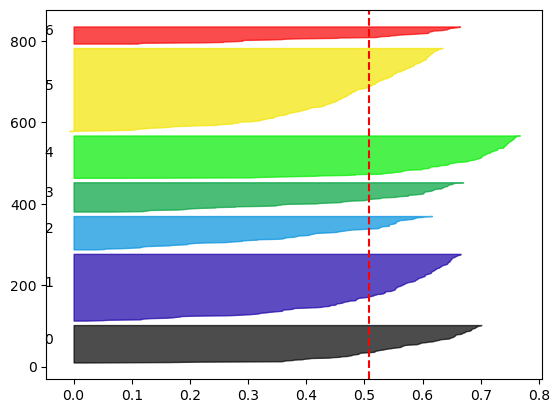

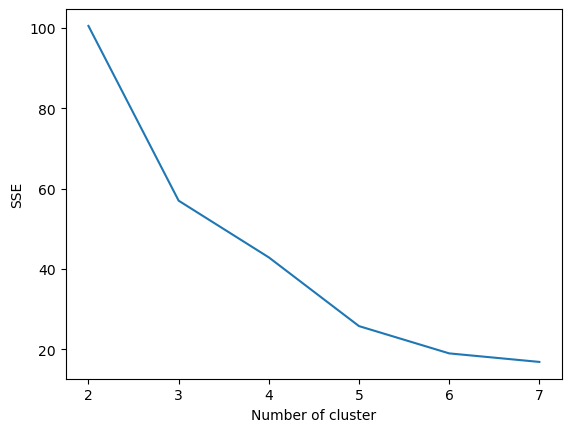

({2: 100.4682, 3: 56.9984, 4: 42.89, 5: 25.7939, 6: 19.0079, 7: 16.8833},
 {2: 0.4431, 3: 0.513, 4: 0.4962, 5: 0.5365, 6: 0.5443, 7: 0.5074})

In [35]:

train_k_means(training_data[wrist_elbow_release_xz],"wrist_elbow_release_xz", True, True)

# Model Selection
After evaulating the silhouette plots and values from above using various features, I think 4 clusters using all of the joints at release time (`all_joints_release_xz`) provided the best clustering model. We actually see most of the time the best silhouette value is for 7 clusters, There are 6 pitchers in the file, and ****INSERT ABOUT CHANGE IN RELEASE*** and it appears as though pitcher NNNNNNN changed their arm path. However, we want this  model to be useful, and arms paths can be pretty distinct -- if we just had a clustering algorithm that assigned a new cluster for each pitcher, that doesnt help us classify arm paths very well. Selecting fewer clusters to generalize arm paths is a more useful model.

In [64]:
wrist_elbow_release_xz

['wrist_x_release', 'wrist_z_release', 'elbow_x_release', 'elbow_z_release']

In [45]:
prod_model_cols = wrist_elbow_release_xz
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(training_data[prod_model_cols])
kmeans = KMeans(n_clusters=4, n_init='auto', max_iter=100, random_state=42).fit(X_train_scaled)
cluster_labels = kmeans.labels_

In [37]:
model_path = "../pitch_path/model"

with open(os.path.join(model_path, "pitch_path.pkl"),'wb') as f:
    pickle.dump(kmeans,f)

with open(os.path.join(model_path, "pitch_path_scaler.pkl"),'wb') as f:
    pickle.dump(scaler,f)

In [38]:
df['cluster_label'] = cluster_labels

In [39]:
df.head()

,distance_traveled_wrist,wrist_x_start,wrist_y_start,wrist_z_start,wrist_x_time_25,wrist_y_time_25,wrist_z_time_25,wrist_x_time_5,wrist_y_time_5,wrist_z_time_5,...,shoulder_x_time_75,shoulder_y_time_75,shoulder_z_time_75,shoulder_x_release,shoulder_y_release,shoulder_z_release,pitcher_id,sched_id,astros_pitch_id,cluster_label
0,13.015431,-1.0854,60.371899,5.1761,-1.2036,60.391399,5.6939,-0.9734,60.047100,5.0402,...,-0.0581,58.776600,4.8104,-0.5841,55.591099,4.4346,680689,429650,1,3
0,13.302328,-1.0651,60.353500,4.7811,-1.2853,60.307598,5.6294,-1.1052,60.004902,5.1368,...,-0.0899,58.809898,4.8387,-0.6146,55.743999,4.4007,680689,429650,2,3
0,12.365136,-1.1921,60.342400,5.2342,-1.2909,60.246799,5.7362,-1.0769,60.020100,4.8710,...,-0.1301,58.790298,4.8485,-0.7695,55.674801,4.4629,680689,429650,3,3
0,13.664919,-1.0934,60.279400,5.0440,-1.2332,60.321999,5.7007,-1.0520,60.067402,4.9439,...,-0.1228,58.736599,4.8103,-0.6916,55.649700,4.4210,680689,429650,4,3
0,15.637433,-1.0301,59.813000,5.2752,-0.5146,60.153500,4.0004,-1.3048,60.417599,5.5970,...,-0.2401,59.987099,5.3549,-0.8248,56.023499,4.5040,680689,429650,5,3


In [40]:
df.groupby(['pitcher_id', 'cluster_label']).size()

pitcher_id  cluster_label
543243      2                101
554430      0                  1
            3                181
641712      1                105
642547      0                 93
            3                  1
669302      1                  1
            2                189
680689      0                  1
            1                  6
            3                 88
dtype: int64

## Get Cluster Centers
Scale cluster centers back to original projection to plot

In [57]:
def plot_cluster_centers(centroids_df: pd.DataFrame, save: bool=False) -> None:
    fig, ax = plt.subplots(1, 1) 
    #fig, ax = plt.figure(figsize=(12, 9))
    #ax = fig.add_subplot(projection='3d')

    for grp_name, grp_idx in centroids_df.groupby(['label']).groups.items():
        x = pd.concat([centroids_df.loc[grp_idx,'wrist_x_release'], centroids_df.loc[grp_idx,'elbow_x_release']])
        z = pd.concat([centroids_df.loc[grp_idx,'wrist_z_release'], centroids_df.loc[grp_idx,'elbow_z_release']])
        ax.scatter(x, z, label=grp_name, s=50, alpha=0.5)
        ax.set_xlabel('x-axis') 
        ax.set_ylabel('z-axis') 
        plt.plot(x, z, linestyle='dashed', marker='s')
    ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
    ax.set_title(f"(X,Z) Release point for {centroids_df.shape[0]} Cluster Centers")
    plt.show()
    if save:
        fig.savefig(f"../img/cluster_center_release_point_{centroids_df.shape[0]}.png")

In [58]:
def get_centroid_df(model, scaler, cols) -> pd.DataFrame:
    centroids=model.cluster_centers_
    centroids_df = pd.DataFrame(scaler.inverse_transform(centroids))
    centroids_df.columns = cols
    centroids_df = centroids_df.reset_index()
    centroids_df = centroids_df.rename(columns={"index": "label"})
    return centroids_df

In [59]:
prod_model_cols

['wrist_x_release', 'wrist_z_release', 'elbow_x_release', 'elbow_z_release']

In [60]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(training_data[prod_model_cols])
kmeans_3 = KMeans(n_clusters=3, n_init='auto', max_iter=100, random_state=42).fit(X_train_scaled)
kmeans_4 = KMeans(n_clusters=4, n_init='auto', max_iter=100, random_state=42).fit(X_train_scaled)
kmeans_5 = KMeans(n_clusters=5, n_init='auto', max_iter=100, random_state=42).fit(X_train_scaled)
kmeans_6 = KMeans(n_clusters=6, n_init='auto', max_iter=100, random_state=42).fit(X_train_scaled)
kmeans_7 = KMeans(n_clusters=7, n_init='auto', max_iter=100, random_state=42).fit(X_train_scaled)
kmeans_8 = KMeans(n_clusters=8, n_init='auto', max_iter=100, random_state=42).fit(X_train_scaled)

In [61]:

centroids_3 = get_centroid_df(kmeans_3, scaler, prod_model_cols)
centroids_4 = get_centroid_df(kmeans_4, scaler, prod_model_cols)
centroids_5 = get_centroid_df(kmeans_5, scaler, prod_model_cols)
centroids_6 = get_centroid_df(kmeans_6, scaler, prod_model_cols)
centroids_7 = get_centroid_df(kmeans_7, scaler, prod_model_cols)
centroids_8 = get_centroid_df(kmeans_8, scaler, prod_model_cols)
cen = [centroids_3, centroids_4, centroids_5, centroids_6, centroids_7, centroids_8]

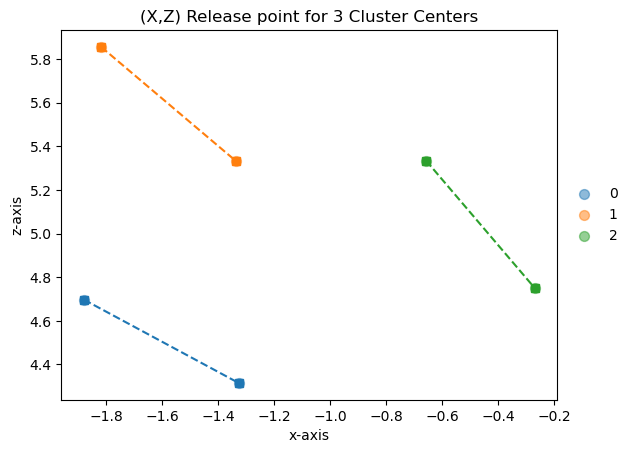

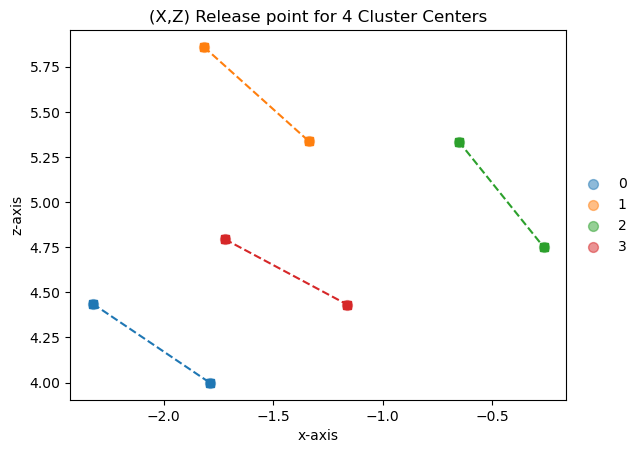

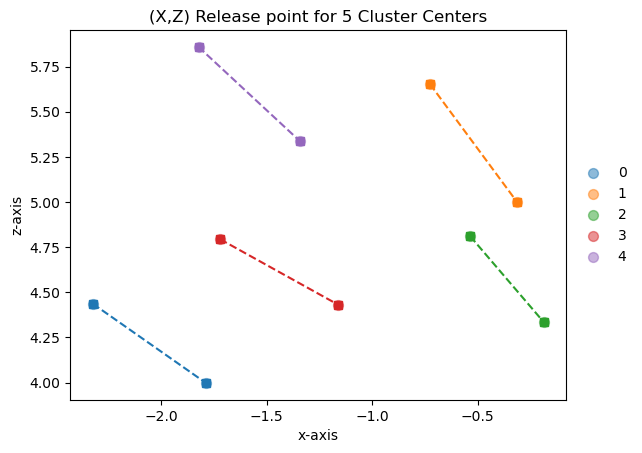

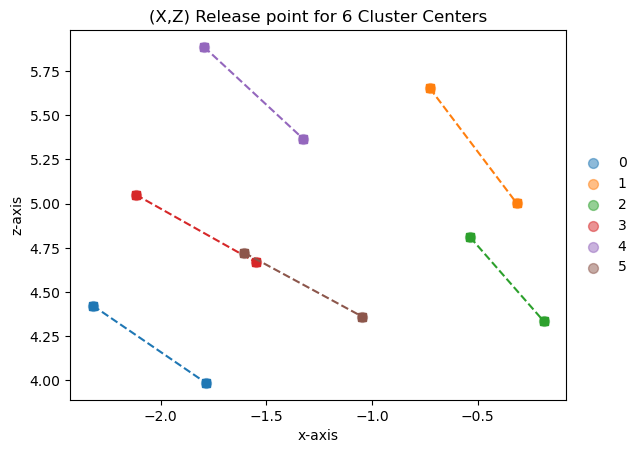

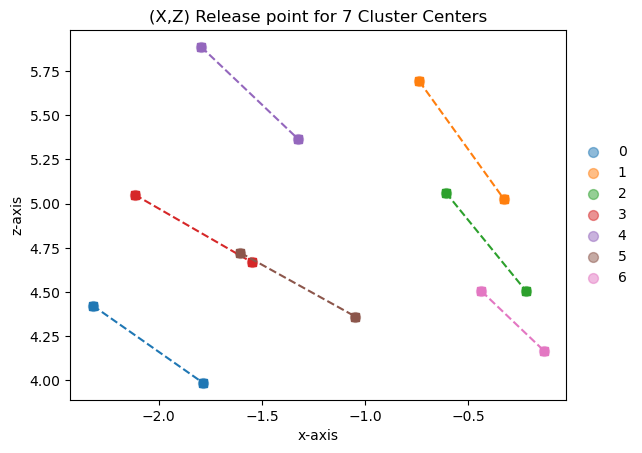

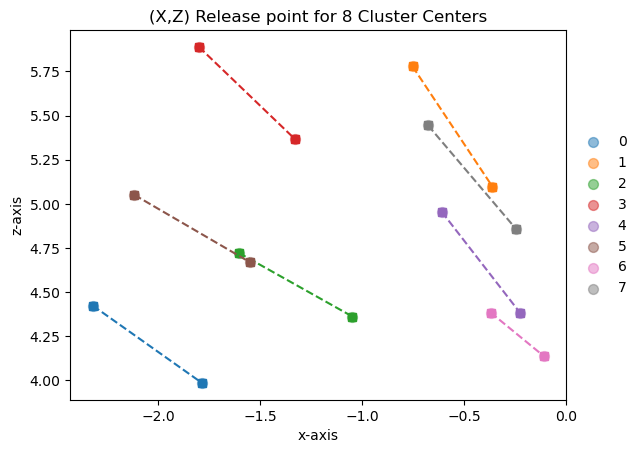

In [63]:
for c in cen:
    plot_cluster_centers(c, True)

## Test Inference

In [23]:
model_path = "../pitch_path/model"
with open(os.path.join(model_path, "pitch_path.pkl"), 'rb') as f:
    model = pickle.load(f)

with open(os.path.join(model_path, "pitch_path_scaler.pkl"), 'rb') as f:
    pitch_path_scaler = pickle.load(f)

all_joints_release_xz = ['wrist_x_release', 'wrist_z_release','elbow_x_release', 'elbow_z_release', 'shoulder_x_release', 'shoulder_z_release']
df_test = pd.read_feather("../data/output/training/training_data")


In [24]:
X =scaler.fit_transform(df_test[all_joints_release_xz])
labels = model.predict(X)

In [85]:
df_test['cluster_label'] = labels
clusters = pd.DataFrame(df_test.groupby(['pitcher_id', 'cluster_label']).size()).reset_index().rename({0: "size"}, axis=1)
clusters.head()

,pitcher_id,cluster_label,size
0,543243,2,101
1,554430,1,181
2,554430,2,1
3,641712,3,105
4,642547,0,94
